Q3.1.1 Volatility Forecasting with GARCH 

Data Preparation:

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from arch import arch_model
import pandas as pd


ticker = "^GSPC"
start_date = "2019-01-01"
end_date = "2023-01-01"
sp500 = yf.download(ticker,start=start_date,end=end_date)["Adj Close"]
returns = sp500.pct_change().dropna()
returns_val = returns.values

# Compute rolling volatility (e.g., 10-day rolling std)
window_size = 10
volatility = pd.Series(returns_val.flatten()).rolling(window=window_size).std().dropna().values 


X, y = [], []
for i in range(len(volatility) - window_size):
    X.append(returns_val[i : i + window_size])  # Use past 10 days of returns
    y.append(volatility[i + window_size]) 

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[*********************100%***********************]  1 of 1 completed


Q3.1.2 Modeling

In [105]:
rolling_predictions = []
test_size = len(returns_val) - 10


for i in range(test_size):
    model = arch_model(returns_val[:-(test_size-i)],vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=10)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

df_rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-test_size:])


c:\Users\gianm\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\gianm\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001773. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\gianm\Ap

Date
2019-01-17 00:00:00+00:00    0.011980
2019-01-18 00:00:00+00:00    0.011425
2019-01-22 00:00:00+00:00    0.010669
2019-01-23 00:00:00+00:00    0.014083
2019-01-24 00:00:00+00:00    0.011885
                               ...   
2022-12-23 00:00:00+00:00    0.013299
2022-12-27 00:00:00+00:00    0.012120
2022-12-28 00:00:00+00:00    0.011126
2022-12-29 00:00:00+00:00    0.011599
2022-12-30 00:00:00+00:00    0.012782
Length: 997, dtype: float64


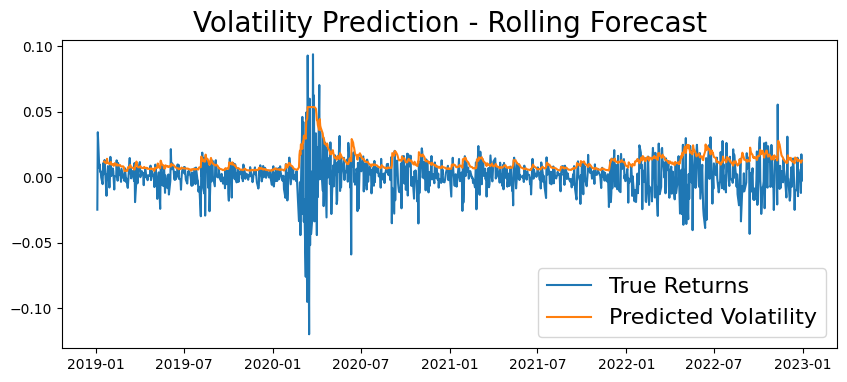

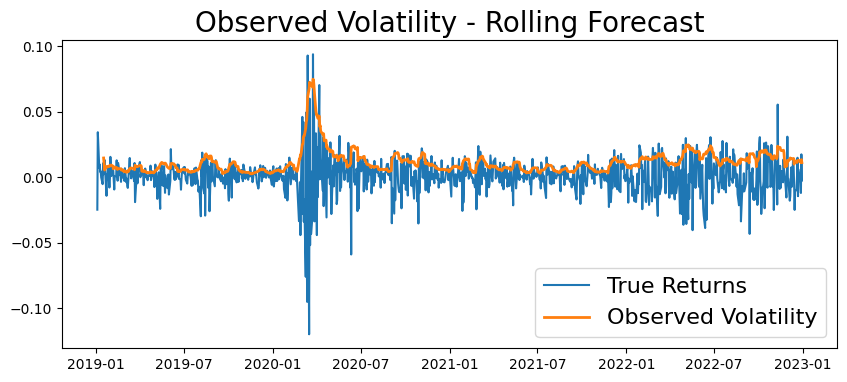

In [118]:
upper_limit = np.percentile(df_rolling_predictions, 99)  # 99th percentile
df_rolling_predictions[df_rolling_predictions > upper_limit] = upper_limit # Clip values
print(df_rolling_predictions)


plt.figure(figsize=(10,4))

true, = plt.plot(returns)
preds, = plt.plot(df_rolling_predictions)

plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

plt.figure(figsize=(10,4))

true, = plt.plot(returns)
observed_volatility = returns.rolling(window=10).std()
plt.plot(observed_volatility, label="Observed Volatility", linewidth=2)

plt.title('Observed Volatility - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Observed Volatility'], fontsize=16)

Q3.1.3 Analysis

In [107]:
from sklearn.metrics import mean_squared_error 
observed_volatility = observed_volatility.dropna()
observed_volatility = observed_volatility[:-1]
mse = mean_squared_error(observed_volatility, rolling_predictions)
print(f"Mean Squared Error (MSE) between observed and predicted volatility: {mse:.6f}")

Mean Squared Error (MSE) between observed and predicted volatility: 0.000006


In [108]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the Neural Network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  
    Dense(32, activation='relu'),
    Dense(1)  # Output layer: Predicts volatility
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


c:\Users\gianm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5240e-04 - val_loss: 9.2208e-05
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6237e-05 - val_loss: 7.3510e-05
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5958e-05 - val_loss: 6.5931e-05
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7447e-05 - val_loss: 6.3535e-05
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2540e-05 - val_loss: 6.4169e-05
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8990e-05 - val_loss: 6.3340e-05
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2515e-05 - val_loss: 6.1000e-05
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4577e-05 - val_loss: 6.2024e-05
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5663e-05 - val_loss: 6.1211e-05
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7984e-05 - val_loss: 5.8618e-05
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0465e-05 - val_loss: 5.9635e-

In [109]:
rolling_predictions = []
test_size = len(X_test)

for i in range(test_size):
    input_data = X_test[i].reshape(1, -1)  # Reshape for prediction
    pred = model.predict(input_data)[0, 0]  # Predict volatility
    rolling_predictions.append(pred)

rolling_predictions = np.array(rolling_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

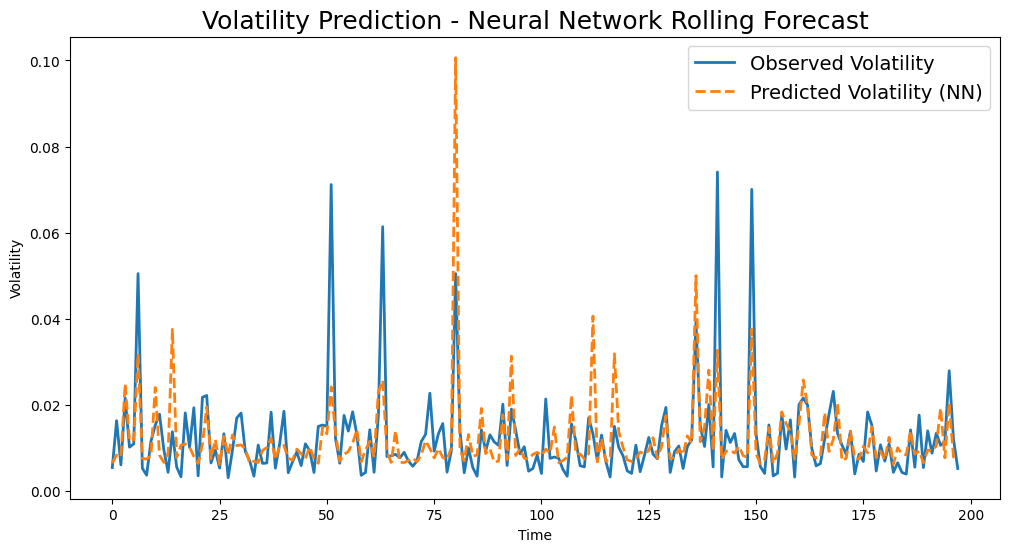

In [116]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Observed Volatility", linewidth=2)
plt.plot(rolling_predictions, label="Predicted Volatility (NN)", linestyle="dashed", linewidth=2)
plt.title("Volatility Prediction - Neural Network Rolling Forecast", fontsize=18)
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()


In [ ]:
nn_rolling_predictions = []
test_size = len(X)

for i in range(test_size):
    input_data = X[i].reshape(1, -1)  # Reshape for prediction
    pred = model.predict(input_data)[0, 0]  # Predict volatility
    nn_rolling_predictions.append(pred)

nn_df_rolling_predictions = pd.Series(nn_rolling_predictions, index=returns.index[-test_size:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

<Figure size 1000x400 with 0 Axes>

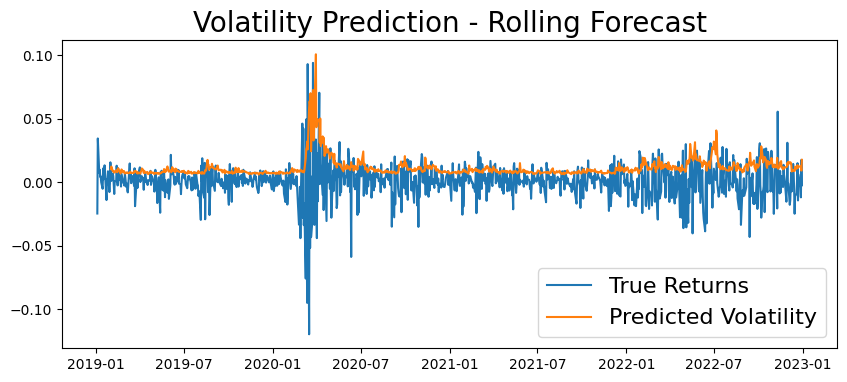

<Figure size 1000x400 with 0 Axes>

In [114]:
plt.figure(figsize=(10,4))

true, = plt.plot(returns)
preds, = plt.plot(nn_df_rolling_predictions)

plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

plt.figure(figsize=(10,4))


In [115]:
 
#observed_volatility = observed_volatility.dropna()
mse = mean_squared_error(y, nn_rolling_predictions)
print(f"Mean Squared Error (MSE) between observed and predicted volatility: {mse:.6f}")

Mean Squared Error (MSE) between observed and predicted volatility: 0.000029
